# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[antoine.bedaton@ulb.be](mailto:antoine.bedaton@ulb.be) - Student ID 459482__
### Student 2 - __[pierre.defraene@ulb.be](mailto:pierre.defraene@ulb.be) - Student ID 463941__
### Student 3 - __[nathan.marotte@ulb.be](mailto:nathan.marotte@ulb.be) - Student ID 459274__

### Video presentation: www.youtube.com/abcd1234

## Project Title


# Introduction

Using data from Taarifa and the Tanzanian Ministry of Water, we are asked to predict which pump are functional, non functional, or need some repairs. The data contains information about each pump (position, region name, population, type of payment, installator, etc ...) and comes in 3 files : 

- training_set_labels : Contains the list of all id followed by their status (functionning, non functionning or needing repairs)

- training_set_values : Contains all the information about each pump with their id that correspond to training_set_labels

- test_set_values : The same structure as training_set_values but for which the status is unknown and that we will have to predict.

First, we will preprocess the data to remove redundent or useless information. For exemple the name of the pump isn't really relevant for guessing if it is working or not, while the name of the constructor is.

Once we reduced the size of the input space, we will run our 3 models on the data, that is training_set_values with their status_group column added.

Our group chose the 3 following models : 

- Neural Network (nnet library)
- Decision Tree (rpart library)
- Random Forest (randomForest library)

We will also need the following libraries 

- Bedabrary
- LibraPierre
- Nadule

Uncomment and execute the following cell to install all the require libraries

In [1]:
# install.packages('dummies')
# install.packages('rpart')
# install.packages('rpart.plot')
# install.packages('nnet')
# install.packages('lazy')
# install.packages('randomForest')

We will be using R in version 3.6.1
This can be checked by executing the following cell

In [2]:
R.version$version.string

[1] "R version 3.6.1 (2019-07-05)"

We will use the data provided by the competition "Pump it Up: Data Mining the Water Table" available [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/])

In [3]:
training_set_labels <- read.csv(file = 'data/training_set_labels.csv')
test_set_values <- read.csv(file = 'data/test_set_values.csv')
training_set_values <- read.csv(file = 'data/training_set_values.csv')

#training_set_labels
#summary(test_set_values)

# Data preprocessing

Before starting the modeling, we must first process the data. We are given a huge number of columns and rows, some of which are not useful to determine the functioning of the pump. For instance, maybe the name of the pump is not important to guess if it is working or not.

## Removing useless columns
First we will check all the columns and check if, by chance, one column has always the same value. If there exist such a column, we can safely delete it since it doesn't bring any information to the model.

In [4]:
for (colname in names(training_set_values)) {
    list_of_unique <- unique(training_set_values[colname])
    if (nrow(list_of_unique) == 1){
        print(paste("the column", colname, "has always the same value"))
    }
}

[1] "the column recorded_by has always the same value"


One column was found that is always the same value, we will then remove it from the dataset

In [5]:
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"recorded_by")] # remove recorded_by

Now we can look at the data in a less strict manner. What if for only a few of the entries, we have a different value ? This won't be detected with the above loop, but can be detected manually by checking the number of occurence of the most common value. If it appears, let's say more than 99 % of the time, we assume it is always that value and remove that column.

In [6]:

# Computes the ratio of the value that appear the most compared to the rest of the data
maxima <- c()
for (colname in names(training_set_values)) {
   maxima <- rbind(maxima, max(table(training_set_values[colname]))/59400)
}

# Shows it nicely
df <- data.frame(names(training_set_values), maxima)
df <- df[order(df$maxima, decreasing=TRUE),]
head(df)


names.training_set_values. maxima   
10 num_private                0.9872559
28 management_group           0.8836700
19 public_meeting             0.8587710
31 water_quality              0.8555219
32 quality_group              0.8555219
37 source_class               0.7709428

We see that num_private has almost 99% of the time the same value. Given the huge amount of columns and data, we do not feel that it is necessary to keep that information, it would only make the model more complicated for a slight change in the error rate. Therefore we delete that column

## Looking at the corelation between columns

When looking through the data, we found multiple columns that were repeated. We suspected that `quantity` and `quantity_group` were highly corolated, so we ran the following command

In [7]:
table(training_set_values$quantity, training_set_values$quantity_group)

              
                 dry enough insufficient seasonal unknown
  dry           6246      0            0        0       0
  enough           0  33186            0        0       0
  insufficient     0      0        15129        0       0
  seasonal         0      0            0     4050       0
  unknown          0      0            0        0     789

It appears that when `quantity` is `dry`, 100% of the time `quantity_group` is also dry. Those two columns have a corelation of 100%, it means one of the two is redundant and can safely be removed.

We could then do that for all the combination of columns, but this isn't efficient and we can decide by ourselves by looking at what the columns represent, and test for corelation between them. This can be done via `chiqs.test` of the contingency table of the two columns. 

For exemple with `quantity` and `quantity_group`

In [8]:
chisq.test(table(training_set_values$quantity, training_set_values$quantity_group))


	Pearson's Chi-squared test

data:  table(training_set_values$quantity, training_set_values$quantity_group)
X-squared = 237600, df = 16, p-value < 2.2e-16


We get a high X-squared value and a very small p-value, this would mean the two columns are highly corrolated.

We then checked all the columns and tested the one we found that might be highly corrolated. Since R is a really bad language, we didn't find a way to do that in a for loop with the name or number of the column in a variable, so we copy-pasted the call with all the columns pair we suspected

In [34]:
head(training_set_values)

chisq.test(table(training_set_values$funder, training_set_values$payment_type))
chisq.test(table(training_set_values$water_quality, training_set_values$quality_group))


id    amount_tsh date_recorded funder              gps_height installer   
1 69572 6000       2011-03-14    Roman               1390       Roman       
2  8776    0       2013-03-06    Grumeti             1399       GRUMETI     
3 34310   25       2013-02-25    Lottery Club         686       World vision
4 67743    0       2013-01-28    Unicef               263       UNICEF      
5 19728    0       2011-07-13    Action In A            0       Artisan     
6  9944   20       2011-03-13    Mkinga Distric Coun    0       DWE         
  longitude latitude   wpt_name             num_private ... payment_type
1 34.93809   -9.856322 none                 0           ... annually    
2 34.69877   -2.147466 Zahanati             0           ... never pay   
3 37.46066   -3.821329 Kwa Mahundi          0           ... per bucket  
4 38.48616  -11.155298 Zahanati Ya Nanyumbu 0           ... never pay   
5 31.13085   -1.825359 Shuleni              0           ... never pay   
6 39.17280   -4.765587 Tajiri               0           ... per bucket  
  water_quality quality_group quantity     quantity_group source              
1 soft          good          enough       enough         spring              
2 soft          good          insufficient insufficient   rainwater harvesting
3 soft          good          enough       enough         dam                 
4 soft          good          dry          dry            machine dbh         
5 soft          good          seasonal     seasonal       rainwater harvesting
6 salty         salty         enough       enough         other               
  source_type          source_class waterpoint_type            
1 spring               groundwater  communal standpipe         
2 rainwater harvesting surface      communal standpipe         
3 dam                  surface      communal standpipe multiple
4 borehole             groundwater  communal standpipe multiple
5 rainwater harvesting surface      communal standpipe         
6 other                unknown      communal standpipe multiple
  waterpoint_type_group
1 communal standpipe   
2 communal standpipe   
3 communal standpipe   
4 communal standpipe   
5 communal standpipe   
6 communal standpipe

Warning message in chisq.test(table(training_set_values$funder, training_set_values$payment_type)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(training_set_values$funder, training_set_values$payment_type)
X-squared = 89600, df = 11382, p-value < 2.2e-16


Warning message in chisq.test(table(training_set_values$water_quality, training_set_values$quality_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(training_set_values$water_quality, training_set_values$quality_group)
X-squared = 297000, df = 35, p-value < 2.2e-16


Before starting the modeling, we need to make sure to keep only the necessary data. In order to do that, we first started to check if there we columns that were 100% equals. To do so, we created a function called $check\_all\_equal$ that will create a combinaison of all the columns of the dataset and will compare them using the $identical$ R function. We noticed that only 2 columns were 100% equals, "quantity" and "quantity_group". Therefore, we decided to remove the "quantity_group" column.

After the first parsing done, we notice that there was still some culumns that were close from being equal but they sometimes differ in one word. For example, the column "payment" and "payment_type" are always the same, they just differ in the notation.


In [91]:
#old_count <- nrow(training_set_values)

In [92]:
#argmax <- tail(names(sort(table(training_set_values$num_private))), 1)  # Finds the value that appear the most
#training_set_values = filter(training_set_values, num_private == argmax)  # Filter and keep all the values equal to one
#print(paste("The number of rows of the dataset has been reduced by", 100*(old_count - nrow(training_set_values))/59400, "%"))

## Missing value imputation

## Feature engineering

## Feature selection

In [10]:
options(repr.matrix.max.rows=10, repr.matrix.max.cols=100) # option pour la taille des prints



 #table(training_set_values$waterpoint_type_group, training_set_values$waterpoint_type)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"waterpoint_type_group")]
 #table(training_set_values$source_type, training_set_values$source_class)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"source_class")]
 #table(training_set_values$source, training_set_values$source_type)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"source_type")]
 #table(training_set_values$water_quality, training_set_values$quality_group)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"quality_group")]
 #table(training_set_values$quantity, training_set_values$quantity_group)  # equivalent, we delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"quantity_group")]
 #table(training_set_values$extraction_type, training_set_values$extraction_type_group)  # we can delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"extraction_type_group")]
 #table(training_set_values$extraction_type, training_set_values$extraction_type_class)  # We can delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"extraction_type_class")]
# table(training_set_values$payment, training_set_values$payment_type)  # equivalent,  we delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"payement_type")]
 #table(training_set_values$management, training_set_values$management_group)  # we delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"management_group")]
 #table(training_set_values$region, training_set_values$region_code)  # very correlated but some cities/code are ambigius
# table(training_set_values$basin, training_set_values$subvillage)  # not really correlated, keep


# head(training_set_values)
names(training_set_values)
length(names(training_set_values))
#training_set_values[-c(40, 38, 37, 33, 35, 26, 27, 31, 29, 14, 12)]
training_set_values
# subvillage > region 
training_set_labels


[1] "id"                "amount_tsh"        "date_recorded"    
 [4] "funder"            "gps_height"        "installer"        
 [7] "longitude"         "latitude"          "wpt_name"         
[10] "basin"             "subvillage"        "region"           
[13] "region_code"       "district_code"     "lga"              
[16] "ward"              "population"        "public_meeting"   
[19] "scheme_management" "scheme_name"       "permit"           
[22] "construction_year" "extraction_type"   "management"       
[25] "payment"           "payment_type"      "water_quality"    
[28] "quantity"          "source"            "waterpoint_type"

[1] 30

id    amount_tsh date_recorded funder          gps_height installer   
1     69572 6000       2011-03-14    Roman           1390       Roman       
2      8776    0       2013-03-06    Grumeti         1399       GRUMETI     
3     34310   25       2013-02-25    Lottery Club     686       World vision
4     67743    0       2013-01-28    Unicef           263       UNICEF      
5     19728    0       2011-07-13    Action In A        0       Artisan     
...   ...   ...        ...           ...             ...        ...         
59396 60739   10       2013-05-03    Germany Republi 1210       CES         
59397 27263 4700       2011-05-07    Cefa-njombe     1212       Cefa        
59398 37057    0       2011-04-11                       0                   
59399 31282    0       2011-03-08    Malec              0       Musa        
59400 26348    0       2011-03-23    World Bank       191       World       
      longitude latitude   wpt_name             basin                  
1     34.93809   -9.856322 none                 Lake Nyasa             
2     34.69877   -2.147466 Zahanati             Lake Victoria          
3     37.46066   -3.821329 Kwa Mahundi          Pangani                
4     38.48616  -11.155298 Zahanati Ya Nanyumbu Ruvuma / Southern Coast
5     31.13085   -1.825359 Shuleni              Lake Victoria          
...   ...       ...        ...                  ...                    
59396 37.16981  -3.253847  Area Three Namba 27  Pangani                
59397 35.24999  -9.070629  Kwa Yahona Kuvala    Rufiji                 
59398 34.01709  -8.750434  Mashine              Rufiji                 
59399 35.86132  -6.378573  Mshoro               Rufiji                 
59400 38.10405  -6.747464  Kwa Mzee Lugawa      Wami / Ruvu            
      subvillage   region      region_code district_code lga           
1     Mnyusi B     Iringa      11           5            Ludewa        
2     Nyamara      Mara        20           2            Serengeti     
3     Majengo      Manyara     21           4            Simanjiro     
4     Mahakamani   Mtwara      90          63            Nanyumbu      
5     Kyanyamisa   Kagera      18           1            Karagwe       
...   ...          ...         ...         ...           ...           
59396 Kiduruni     Kilimanjaro  3          5             Hai           
59397 Igumbilo     Iringa      11          4             Njombe        
59398 Madungulu    Mbeya       12          7             Mbarali       
59399 Mwinyi       Dodoma       1          4             Chamwino      
59400 Kikatanyemba Morogoro     5          2             Morogoro Rural
      ward             population public_meeting scheme_management
1     Mundindi         109        True           VWC              
2     Natta            280                       Other            
3     Ngorika          250        True           VWC              
4     Nanyumbu          58        True           VWC              
5     Nyakasimbi         0        True                            
...   ...              ...        ...            ...              
59396 Masama Magharibi 125        True           Water Board      
59397 Ikondo            56        True           VWC              
59398 Chimala            0        True           VWC              
59399 Mvumi Makulu       0        True           VWC              
59400 Ngerengere       150        True           VWC              
      scheme_name                 permit construction_year extraction_type
1     Roman                       False  1999              gravity        
2                                 True   2010              gravity        
3     Nyumba ya mungu pipe scheme True   2009              gravity        
4                                 True   1986              submersible    
5                                 True      0              gravity        
...   ...                         ...    ...               ...            
59396 Losaa Kia water sup

id    status_group  
1     69572 functional    
2      8776 functional    
3     34310 functional    
4     67743 non functional
5     19728 functional    
...   ...   ...           
59396 60739 functional    
59397 27263 functional    
59398 37057 functional    
59399 31282 functional    
59400 26348 functional

At this time, we have remove the column which gave less information or was redundant. Now, we want to look after the correlation between the value and the output

In [11]:
factor_variables <- which(sapply(training_set_values[1,],class)=="factor")
#factor_variables

only_num_var <- training_set_values[,-factor_variables]

#data_train
data_train <- cbind(only_num_var, training_set_labels[2])
data_train

summary(data_train)


id    amount_tsh gps_height longitude latitude   region_code
1     69572 6000       1390       34.93809   -9.856322 11         
2      8776    0       1399       34.69877   -2.147466 20         
3     34310   25        686       37.46066   -3.821329 21         
4     67743    0        263       38.48616  -11.155298 90         
5     19728    0          0       31.13085   -1.825359 18         
...   ...   ...        ...        ...       ...        ...        
59396 60739   10       1210       37.16981  -3.253847   3         
59397 27263 4700       1212       35.24999  -9.070629  11         
59398 37057    0          0       34.01709  -8.750434  12         
59399 31282    0          0       35.86132  -6.378573   1         
59400 26348    0        191       38.10405  -6.747464   5         
      district_code population construction_year status_group  
1      5            109        1999              functional    
2      2            280        2010              functional    
3      4            250        2009              functional    
4     63             58        1986              non functional
5      1              0           0              functional    
...   ...           ...        ...               ...           
59396 5             125        1999              functional    
59397 4              56        1996              functional    
59398 7               0           0              functional    
59399 4               0           0              functional    
59400 2             150        2002              functional

       id          amount_tsh         gps_height       longitude    
 Min.   :    0   Min.   :     0.0   Min.   : -90.0   Min.   : 0.00  
 1st Qu.:18520   1st Qu.:     0.0   1st Qu.:   0.0   1st Qu.:33.09  
 Median :37062   Median :     0.0   Median : 369.0   Median :34.91  
 Mean   :37115   Mean   :   317.7   Mean   : 668.3   Mean   :34.08  
 3rd Qu.:55657   3rd Qu.:    20.0   3rd Qu.:1319.2   3rd Qu.:37.18  
 Max.   :74247   Max.   :350000.0   Max.   :2770.0   Max.   :40.35  
    latitude        region_code   district_code     population     
 Min.   :-11.649   Min.   : 1.0   Min.   : 0.00   Min.   :    0.0  
 1st Qu.: -8.541   1st Qu.: 5.0   1st Qu.: 2.00   1st Qu.:    0.0  
 Median : -5.022   Median :12.0   Median : 3.00   Median :   25.0  
 Mean   : -5.706   Mean   :15.3   Mean   : 5.63   Mean   :  179.9  
 3rd Qu.: -3.326   3rd Qu.:17.0   3rd Qu.: 5.00   3rd Qu.:  215.0  
 Max.   :  0.000   Max.   :99.0   Max.   :80.00   Max.   :30500.0  
 construction_year                  statu

We need to transform also categorical variable with 'one-hot-encoding'. To do so, we will use `dummies` package  

In [12]:
install.packages('dummies')
library(dummies)

package 'dummies' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\natha\AppData\Local\Temp\RtmpkFGv6k\downloaded_packages


dummies-1.5.6 provided by Decision Patterns



In [13]:
data_factor <- training_set_values[,factor_variables]

In [14]:
variables_to_keep <- c("funder","extraction_type")

data_factor_onehot <- dummy.data.frame(data_factor[,variables_to_keep], sep="_")

dim(data_factor_onehot)
data_factor_onehot[1:2,]

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

[1] 59400  1916

funder_ funder_0 funder_A/co Germany funder_Aar funder_Abas Ka funder_Abasia
1 0       0        0                   0          0              0            
2 0       0        0                   0          0              0            
  funder_Abc-ihushi Development Cent funder_Abd funder_Abdala funder_Abddwe
1 0                                  0          0             0            
2 0                                  0          0             0            
  funder_Abdul funder_Abood funder_Abs funder_Aco/germany funder_Acord
1 0            0            0          0                  0           
2 0            0            0          0                  0           
  funder_Acord Ngo funder_Acra funder_Act funder_Act Mara funder_Action Aid
1 0                0           0          0               0                
2 0                0           0          0               0                
  funder_Action Contre La Faim funder_Action In A funder_Adap funder_Adb
1 0                            0                  0           0         
2 0                            0                  0           0         
  funder_Adf funder_Adp funder_Adp Bungu funder_Adp Mombo funder_Adp/w
1 0          0          0                0                0           
2 0          0          0                0                0           
  funder_Adra funder_Af funder_Afdp funder_Afric funder_Africa
1 0           0         0           0            0            
2 0           0         0           0            0            
  funder_Africa 2000 Network/undp funder_Africa Amini Alama
1 0                               0                        
2 0                               0                        
  funder_Africa Project Ev Germany funder_African funder_African 2000 Network
1 0                                0              0                          
2 0                                0              0                          
  funder_African Barrick Gold funder_African Development Bank
1 0                           0                              
2 0                           0                              
  funder_African Development Foundation funder_African Muslim Agency
1 0                                     0                           
2 0                                     0                           
  funder_African Realief Committe Of Ku funder_African Reflections Foundation
1 0                                     0                                    
2 0                                     0                                    
  funder_African Relie funder_Africaone Ltd funder_Africare
1 0                    0                    0              
2 0                    0                    0              
  funder_Afriican Reli funder_Afroz Ismail ... funder_World Bank
1 0                    0                   ... 0                
2 0                    0                   ... 0                
  funder_World Bank/government funder_World Vision funder_World Vision/ Kkkt
1 0                            0                   0                        
2 0                            0                   0                        
  funder_World Vision/adra funder_World Vision/rc Church funder_Worldvision
1 0                        0                             0                 
2 0                        0                             0                 
  funder_Woyege funder_Wrssp funder_Wsdo funder_Wsdp funder_Wsdp & Sdg
1 0             0            0           0           0                
2 0             0            0           0           0                
  funder_Wspd funder_Wssp funder_Wua funder_Wua And Ded funder_Wug And Ded
1 0           0           0          0                  0                 
2 0           0           0          0                  0                 
  funder_Wvc funder_Wvt funder_Wwf funder_Wwf / Fores funder_Yaole
1 0          0          0          0                  0           
2 0          0          0   

# Model selection

## Model 1

## Model 2

## Model 3

#### Example of simple equation
\begin{equation}
e = mc^2
\end{equation}

#### Example of matrix equation - Cross product formula:

\begin{equation*}
\mathbf{V}_1 \times \mathbf{V}_2 =  \begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial X}{\partial u} &  \frac{\partial Y}{\partial u} & 0 \\
\frac{\partial X}{\partial v} &  \frac{\partial Y}{\partial v} & 0
\end{vmatrix}
\end{equation*}

#### Example of multiline equation - The Lorenz Equations:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

#### Example of Markdown Table:

| This | is   |
|------|------|
|   a  | table|


In [15]:
#install decision tree
install.packages("rpart")
install.packages("rpart.plot")

package 'rpart' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\natha\AppData\Local\Temp\RtmpkFGv6k\downloaded_packages
package 'rpart.plot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\natha\AppData\Local\Temp\RtmpkFGv6k\downloaded_packages


Warning message:
"package 'rpart' was built under R version 3.6.3"Warning message:
"package 'rpart.plot' was built under R version 3.6.3"

id    amount_tsh gps_height longitude latitude   region_code
1     69572 6000       1390       34.93809   -9.856322 11         
2      8776    0       1399       34.69877   -2.147466 20         
3     34310   25        686       37.46066   -3.821329 21         
4     67743    0        263       38.48616  -11.155298 90         
5     19728    0          0       31.13085   -1.825359 18         
...   ...   ...        ...        ...       ...        ...        
59396 60739   10       1210       37.16981  -3.253847   3         
59397 27263 4700       1212       35.24999  -9.070629  11         
59398 37057    0          0       34.01709  -8.750434  12         
59399 31282    0          0       35.86132  -6.378573   1         
59400 26348    0        191       38.10405  -6.747464   5         
      district_code population construction_year status_group  
1      5            109        1999              functional    
2      2            280        2010              functional    
3      4            250        2009              functional    
4     63             58        1986              non functional
5      1              0           0              functional    
...   ...           ...        ...               ...           
59396 5             125        1999              functional    
59397 4              56        1996              functional    
59398 7               0           0              functional    
59399 4               0           0              functional    
59400 2             150        2002              functional

id    status_group  
1     50785 functional    
2     51630 functional    
3     17168 functional    
4     45559 non functional
5     49871 functional    
...   ...   ...           
14846 39307 non functional
14847 18990 functional    
14848 28749 functional    
14849 33492 functional    
14850 68707 functional

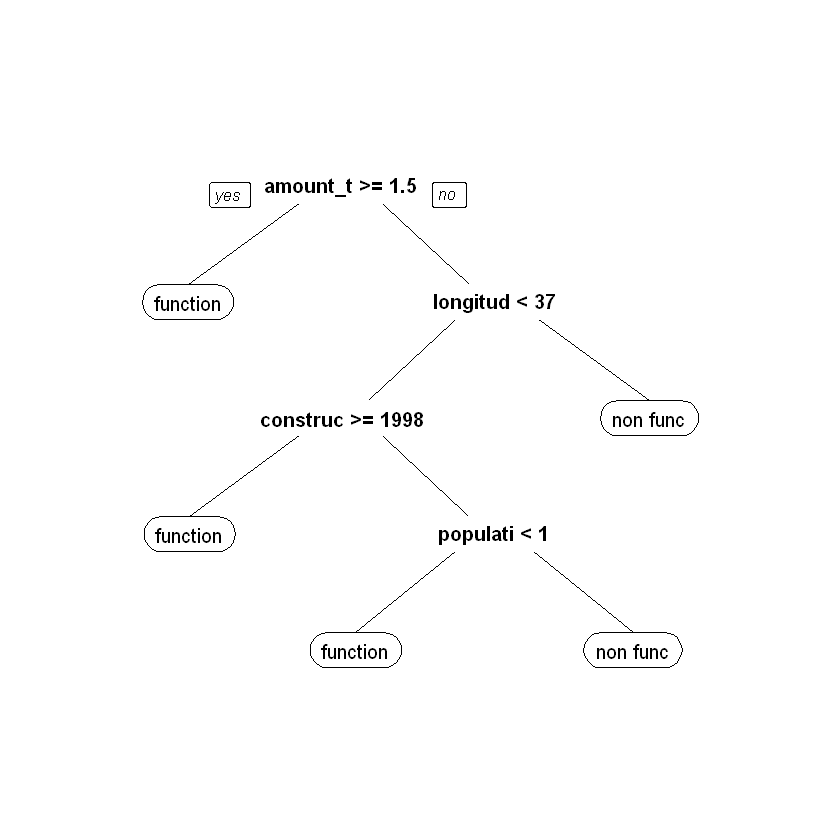

In [16]:

library(rpart)
library(rpart.plot)

data_train

# example model 

#DS <- cbind(X, functionnal=Y)
#data_train doit encore être défini data input + status_group

model<- rpart(status_group~., data= data_train, method = 'class') # what we need to change according of the model

prp(model)

predict_unseen <- predict(model,test_set_values, type = 'class')

status_group <-predict_unseen

data_predict <- test_set_values


data_predict <- cbind(data_predict[1],status_group)

data_predict

#write.csv(data_predict,"decisionTree.csv",row.names = FALSE)







We will also try to make the prediction with neural networks.

In [17]:
install.packages("nnet")


  There is a binary version available but the source version is later:
     binary source needs_compilation
nnet 7.3-15 7.3-16              TRUE

  Binaries will be installed
package 'nnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\natha\AppData\Local\Temp\RtmpkFGv6k\downloaded_packages


In [18]:
library(nnet)

data_train

# example model 

#DS <- cbind(X, functionnal=Y)
#data_train doit encore être défini data input + status_group

nnet_model <- nnet(status_group~., data= data_train, size = 8, decay=5e-4, maxit=200) # what we need to change according of the model


predict_unseen <- predict(nnet_model, test_set_values, type= 'class')

status_group <-predict_unseen

nnet_data_predict <- cbind(data_predict[1],status_group)

nnet_data_predict

table(nnet_data_predict["status_group"] == "functional")

#write.csv(nnet_data_predict,"NeuralNetwork.csv",row.names = FALSE)

Warning message:
"package 'nnet' was built under R version 3.6.3"

id    amount_tsh gps_height longitude latitude   region_code
1     69572 6000       1390       34.93809   -9.856322 11         
2      8776    0       1399       34.69877   -2.147466 20         
3     34310   25        686       37.46066   -3.821329 21         
4     67743    0        263       38.48616  -11.155298 90         
5     19728    0          0       31.13085   -1.825359 18         
...   ...   ...        ...        ...       ...        ...        
59396 60739   10       1210       37.16981  -3.253847   3         
59397 27263 4700       1212       35.24999  -9.070629  11         
59398 37057    0          0       34.01709  -8.750434  12         
59399 31282    0          0       35.86132  -6.378573   1         
59400 26348    0        191       38.10405  -6.747464   5         
      district_code population construction_year status_group  
1      5            109        1999              functional    
2      2            280        2010              functional    
3      4            250        2009              functional    
4     63             58        1986              non functional
5      1              0           0              functional    
...   ...           ...        ...               ...           
59396 5             125        1999              functional    
59397 4              56        1996              functional    
59398 7               0           0              functional    
59399 4               0           0              functional    
59400 2             150        2002              functional

# weights:  107
initial  value 100560.046440 
iter  10 value 53021.975401
iter  20 value 52822.620975
iter  30 value 52809.822412
iter  40 value 52806.672485
iter  50 value 52803.836082
iter  60 value 52801.425499
iter  70 value 52799.723181
iter  80 value 52799.274884
iter  90 value 52798.271571
iter 100 value 52797.308079
iter 110 value 52796.660671
iter 120 value 52796.087047
iter 130 value 52795.531306
final  value 52795.526001 
converged


id    status_group
1     50785 functional  
2     51630 functional  
3     17168 functional  
4     45559 functional  
5     49871 functional  
...   ...   ...         
14846 39307 functional  
14847 18990 functional  
14848 28749 functional  
14849 33492 functional  
14850 68707 functional


FALSE  TRUE 
   54 14796 

In [19]:
predict_unseen <- predict(nnet_model,only_num_var, type= 'class')

In [20]:
results <- table(ifelse(predict_unseen == training_set_labels$status_group, "true", "false"))
results["true"]/(results["true"]+results["false"])

true 
0.5437205

We will also look after the lazy model

In [21]:
install.packages('lazy')

package 'lazy' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\natha\AppData\Local\Temp\RtmpkFGv6k\downloaded_packages


In [22]:
library(lazy)

model<- lazy(status_group~., data= data_train) # what we need to change according of the model


predict_unseen <- predict(model,test_set_values, type = 'class')

predict_unseen

status_group <-predict_unseen

data_predict <- test_set_values


data_predict <- cbind(data_predict[1],status_group)

#table(data_predict["status_group"] == "functional")

data_predict

#write.csv(data_predict,"lazy.csv",row.names = FALSE)

Warning message in model.response(mf, "numeric"):
"using type = "numeric" with a factor response will be ignored"

$h
    [1]  2.073517e+00  1.451232e+00  1.173736e+00  2.449443e+00  1.554772e+00
    [6]  2.143512e+00  1.598650e+00  2.948526e+00  2.758691e+00  1.197193e+00
   [11]  1.244513e+00  2.052628e+00  1.800586e+00  1.997958e+00  1.419141e+00
   [16]  1.314235e+00  3.844618e+00  2.462589e+00  1.712346e+00  2.750272e+00
   [21]  1.265109e+00  1.735757e+00  2.170777e+00  2.794934e+00  1.772956e+00
   [26]  1.488572e+00  2.940390e+00  1.031599e+00  1.669911e+00  1.967677e+00
   [31]  6.208169e-01  1.825280e+00  2.002850e+00  1.320915e+00  1.875846e+00
   [36]  8.699608e-01  4.208452e+00  1.056654e+00  2.500994e+00  1.652531e+00
   [41]  2.103285e+00  2.315834e+00  1.940206e+00  1.837177e+00  1.939732e+00
   [46]  1.982934e+00  1.887570e+00  1.689607e+00  2.086999e+00  1.731775e+00
   [51]  1.616797e+00  2.613824e+00  1.269865e+00  2.182253e+00  2.033974e+00
   [56]  1.319440e+00  1.320715e+00  2.632534e+00  1.845052e+00  1.223367e+00
   [61]  1.916246e+00  1.768828e+00  1.436522e+00  2.171595e+00  2.621588e+00
   [66]  1.222018e+00  2.410327e+00  2.832370e+00  1.349894e+00  6.693051e-01
   [71]  2.480368e+00  2.332361e+00  1.490627e+00  1.232483e+00  2.841036e+00
   [76]  1.857678e+00 -3.246883e-01  1.377013e+00  1.597287e+00  2.440688e+00
   [81]  1.300159e+00  1.707286e+00  1.943611e+00  1.858622e+00  1.354618e+00
   [86]  2.113770e+00  1.626553e+00  1.941855e+00  3.072026e+00  1.710784e+00
   [91]  1.281397e+00  1.553772e+00  2.228948e+00  3.503701e+00  1.034886e+00
   [96]  2.030995e+00  1.574907e+00  1.136319e+00  1.921344e+00  1.982981e+00
  [101]  2.587739e+00  1.783466e+00  1.621933e+00  1.436750e+00  2.637384e+00
  [106]  1.760368e+00  1.948713e+00  2.094817e+00  1.574163e+00  2.220818e+00
  [111]  1.625163e+00  1.917226e+00  1.204948e+00  1.328380e+00  1.736576e+00
  [116]  2.410453e+00  1.733520e+00  1.723575e+00  2.150806e+00  1.839761e+00
  [121]  2.308610e+00  1.633098e+00  2.844269e+00  1.814990e+00  1.428736e+00
  [126]  1.656317e+00  1.914136e+00  1.353787e+00  2.283305e+00  1.854379e+00
  [131]  8.660589e-01  1.854403e+00  2.018793e+00  3.074675e+00  1.527752e+00
  [136]  2.140715e+00  1.666677e+00  1.964872e+00  1.027722e+00  2.301533e+00
  [141]  1.279693e+00  1.785854e+00  2.588319e+00  2.368278e+00  1.962872e+00
  [146]  1.533124e+00  1.765928e+00  1.996268e+00  1.522135e+00  2.228273e+00
  [151]  2.000747e+00  1.413210e+00  1.536279e+00  1.695047e+00  1.624554e+00
  [156]  2.337176e+00  2.022019e+00  2.151575e+00  3.819594e-01  2.184295e+00
  [161]  1.587954e+00  2.433578e+00  2.968369e+00  2.869183e+00  1.612834e+00
  [166]  2.250244e+00  1.919995e+00  1.378499e+00  1.876672e+00  7.355511e-01
  [171]  1.605114e+00  1.779064e+00  2.299762e+00  1.971014e+00  2.268998e+00
  [176]  2.028833e+00  1.951908e+00  2.877824e+00  1.182227e+00  9.064977e-01
  [181]  2.810108e+00  1.165476e+00  1.572224e+00  1.636382e+00  1.406100e+00
  [186]  2.076832e+00  1.957350e+00  2.211364e+00  1.578174e+00  1.940443e+00
  [191]  2.127987e+00  1.513732e+00  1.476838e+00  9.528452e-01  1.711849e+00
  [196]  2.043173e+00  1.431553e+00  2.446684e+00  1.384803e+00  3.169912e+00
  [201]  1.889641e+00  1.774922e+00  1.921110e+00  2.659901e+00  2.006753e+00
  [206]  2.001417e+00  2.787409e+00  1.839793e+00  2.082688e+00  9.165554e-01
  [211]  2.020153e+00  2.656846e+00  2.462420e+00  2.146097e+00  3.037379e+00
  [216]  1.205532e+00  1.918930e+00  1.409094e+00  1.018545e+00  1.756878e+00
  [221]  2.071832e+00  2.416219e+00  2.063513e+00  1.441738e+00  2.444589e+00
  [226]  1.920151e+00  9.898645e-01  1.368880e+00  1.813328e+00  1.440219e+00
  [231]  2.875171e+00  2.290454e+00  2.117272e+00  2.036349e+00  2.214943e+00
  [236]  1.086731e+00  1.671393e+00  1.359922e+00  2.310723e-01  7.670454e-01
  [241]  1.855568e+00  2.343470e+00  2.466814e+00  1.502807e+00  2.056934e+00
  [246]  1.129565e+00  1.479645e+00  1.949752e+00  7.871979e-01  1.926027e+00
  [251]  1.418007e+00  2.059029e+00  1.817420e+00  1.109190e+00  1.214395e+00
  [256]  1.228300e+

id    h       
1     50785 2.073517
2     51630 1.451232
3     17168 1.173736
4     45559 2.449443
5     49871 1.554772
...   ...   ...     
14846 39307 2.936169
14847 18990 1.160669
14848 28749 1.167073
14849 33492 1.898517
14850 68707 2.058096

In [23]:
install.packages("randomForest")
library("randomForest")

model<- randomForest(formula = status_group~., data= data_train) # what we need to change according of the model

package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\natha\AppData\Local\Temp\RtmpkFGv6k\downloaded_packages


Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [24]:
rf_model<- randomForest(status_group~., data= data_train) # what we need to change according of the model


rf_predict_unseen <- predict(rf_model,test_set_values, type = 'class')

rf_predict_unseen

status_group <-rf_predict_unseen

rf_data_predict <- test_set_values


rf_data_predict <- cbind(data_predict[1],status_group)

#table(data_predict["status_group"] == "functional")

rf_data_predict

#write.csv(data_predict,"lazy.csv",row.names = FALSE)

1                       2                       3 
             functional              functional              functional 
                      4                       5                       6 
         non functional              functional              functional 
                      7                       8                       9 
             functional          non functional          non functional 
                     10                      11                      12 
             functional              functional          non functional 
                     13                      14                      15 
         non functional          non functional              functional 
                     16                      17                      18 
             functional              functional              functional 
                     19                      20                      21 
             functional          non functional              functional 
                     22                      23                      24 
             functional          non functional          non functional 
                     25                      26                      27 
             functional              functional          non functional 
                     28                      29                      30 
         non functional              functional          non functional 
                     31                      32                      33 
             functional          non functional          non functional 
                     34                      35                      36 
             functional              functional              functional 
                     37                      38                      39 
             functional functional needs repair          non functional 
                     40                      41                      42 
             functional          non functional              functional 
                     43                      44                      45 
             functional              functional              functional 
                     46                      47                      48 
             functional          non functional              functional 
                     49                      50                      51 
             functional              functional              functional 
                     52                      53                      54 
             functional          non functional          non functional 
                     55                      56                      57 
         non functional              functional              functional 
                     58                      59                      60 
         non functional              functional          non functional 
                     61                      62                      63 
             functional              functional              functional 
                     64                      65                      66 
         non functional              functional              functional 
                     67                      68                      69 
         non functional          non functional              functional 
                     70                      71                      72 
         non functional          non functional functional needs repair 
                     73                      74                      75 
         non functional          non functional          non functional 
                     76                      77                      78 
             functional              functional              functional 
                     79                      80                      81 
             functional          non functional          non functional 
                     82                      83                      84 
       

id    status_group  
1     50785 functional    
2     51630 functional    
3     17168 functional    
4     45559 non functional
5     49871 functional    
...   ...   ...           
14846 39307 non functional
14847 18990 functional    
14848 28749 functional    
14849 33492 functional    
14850 68707 non functional

In [25]:
model


Call:
 randomForest(formula = status_group ~ ., data = data_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 28.41%
Confusion matrix:
                        functional functional needs repair non functional
functional                   27474                     424           4361
functional needs repair       2700                     770            847
non functional                8322                     223          14279
                        class.error
functional                0.1483307
functional needs repair   0.8216354
non functional            0.3743866

# Alternative models





# Conclusions